In [1]:
!pip install colorama
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
from typing import Tuple, Union
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import Levenshtein
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torchvision import datasets, transforms

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

import sys
from itertools import groupby

import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from colorama import Fore
from tqdm import tqdm
from torch.utils.data import SubsetRandomSampler
from pathlib import Path
from dataclasses import dataclass

In [3]:
@dataclass
class ExpCONFIG:
    seed: int
    epochs: int
    batch_size: int
    arch: str
    logdir: Path
    init_lr: float
    validation_split: float
    device: torch.device
    len_of_mnist_sequence: Tuple[int, int]
    digits_per_sequence: int
    num_classes: int = None
    blank_label: int = None

In [4]:
class CapchaDataset(Dataset):
    """
    Датасет генерирует капчу длины seq_len из набора данных EMNIST
    """

    def __init__(
        self,
        seq_len: Union[int, Tuple[int, int]],
        img_h: int = 28,
        split: str = "digits",
        samples: int = None,
    ):
        self.emnist_dataset = datasets.EMNIST(
            "./EMNIST", split=split, train=True, download=True
        )
        self.seq_len = seq_len
        self.blank_label = len(self.emnist_dataset.classes)
        self.img_h = img_h
        self.samples = samples
        self.num_classes = len(self.emnist_dataset.classes) + 1
        if isinstance(seq_len, int):
            self._min_seq_len = seq_len
            self._max_seq_len = seq_len
        elif (
            isinstance(seq_len, Tuple)
            and len(seq_len) == 2
            and isinstance(seq_len[0], int)
        ):
            self._min_seq_len = seq_len[0]
            self._max_seq_len = seq_len[1]

    def __len__(self):
        """
        Можно нагенерировать N различных капчей, где N - число сочетаний с повторениями.
        Если задано samples - вернуть его
        """
        if self.samples is not None:
            return self.samples
        return len(self.emnist_dataset.classes) ** self._max_seq_len

    def __preprocess(self, random_images: torch.Tensor) -> np.ndarray:
        transformed_images = []
        for img in random_images:
            img = transforms.ToPILImage()(img)
            img = TF.rotate(img, -90, fill=[0.0])
            img = TF.hflip(img)
            img = transforms.ToTensor()(img).numpy()
            transformed_images.append(img)
        images = np.array(transformed_images)
        images = np.hstack(
            images.reshape((len(transformed_images), self.img_h, self.img_h))
        )
        full_img = np.zeros(shape=(self.img_h, self._max_seq_len * self.img_h)).astype(
            np.float32
        )
        full_img[:, 0 : images.shape[1]] = images
        return full_img

    def __getitem__(self, idx):
        # Get random seq_len
        random_seq_len = np.random.randint(self._min_seq_len, self._max_seq_len + 1)
        # Get random ind
        random_indices = np.random.randint(
            len(self.emnist_dataset.data), size=(random_seq_len,)
        )
        random_images = self.emnist_dataset.data[random_indices]
        random_digits_labels = self.emnist_dataset.targets[random_indices]
        labels = torch.zeros((1, self._max_seq_len))
        labels = torch.fill(labels, self.blank_label)
        labels[0, 0 : len(random_digits_labels)] = random_digits_labels
        x = self.__preprocess(random_images)
        y = labels.numpy().reshape(self._max_seq_len)
        return x, y

In [30]:
def is_correct(prediction, y_true, blank):
    prediction = prediction.to(torch.int32)
    prediction = prediction[prediction != blank]
    y_true = y_true.to(torch.int32)
    y_true = y_true[y_true != blank]
    return len(prediction) == len(y_true) and torch.all(prediction.eq(y_true))


def train_epoch(model, criterion, optimizer, data_loader, config: ExpCONFIG) -> None:
    model.train()
    train_correct = 0
    train_total = 0
    total_distance = 0
    for x_train, y_train in tqdm(
            data_loader,
            position=0,
            leave=True,
            file=sys.stdout,
            bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET),
    ):
        batch_size = x_train.shape[0]  # x_train.shape == torch.Size([64, 28, 140])
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
        optimizer.zero_grad()
        y_pred = model(x_train.to(config.device))
        # print(f"{y_pred.shape=}")
        y_pred = y_pred.permute(1, 0, 2)  # y_pred.shape == torch.Size([64, 32, 11])
        input_lengths = torch.IntTensor(batch_size).fill_(model.cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_train])
        loss = criterion(y_pred, y_train, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        _, max_index = torch.max(
            y_pred, dim=2
        )
        for i in range(batch_size):
            raw_prediction = list(
                max_index[:, i].detach().cpu().numpy()
            )
            prediction = torch.IntTensor(
                [c for c, _ in groupby(raw_prediction) if c != config.blank_label]
            )
            prediction = prediction.to(torch.int32)[prediction != config.blank_label]
            y_true = y_train[i].to(torch.int32)[y_train[i] != config.blank_label]

            if len(prediction) == len(y_true) and torch.all(prediction.eq(y_true)):
                train_correct += 1
            train_total += 1
            total_distance += Levenshtein.distance(prediction.tolist(), y_true.tolist())
    acc = train_correct / train_total
    avg_distance = total_distance / train_total
    print('TRAINING. Correct (accuracy): ', train_correct, '/', train_total, '=', acc)
    print("TRAINING. Average Levenshtein distance:", avg_distance)



def valid_epoch(model, val_loader, config: ExpCONFIG) -> float:
    model.eval()
    with torch.no_grad():
        val_correct = 0
        val_total = 0
        total_distance = 0
        for x_val, y_val in tqdm(
                val_loader,
                position=0,
                leave=True,
                file=sys.stdout,
                bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Fore.RESET),
        ):
            batch_size = x_val.shape[0]
            x_val = x_val.view(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2])
            y_pred = model(x_val.to(config.device))
            y_pred = y_pred.permute(1, 0, 2)
            input_lengths = torch.IntTensor(batch_size).fill_(model.cnn_output_width)
            target_lengths = torch.IntTensor([len(t) for t in y_val])
            criterion(y_pred, y_val, input_lengths, target_lengths)
            _, max_index = torch.max(y_pred, dim=2)
            for i in range(batch_size):
                raw_prediction = list(max_index[:, i].detach().cpu().numpy())
                prediction = torch.IntTensor(
                    [c for c, _ in groupby(raw_prediction) if c != config.blank_label]
                )
                prediction = prediction.to(torch.int32)[prediction != config.blank_label]
                y_true = y_val[i].to(torch.int32)[y_val[i] != config.blank_label]

                if len(prediction) == len(y_true) and torch.all(prediction.eq(y_true)):
                    val_correct += 1
                val_total += 1
                total_distance += Levenshtein.distance(prediction.tolist(), y_true.tolist())
        acc = val_correct / val_total
        avg_distance = total_distance / val_total
        print("VALID. Correct (accuracy): ", val_correct, "/", val_total, "=", acc)
        print("VALID. Average Levenshtein distance:", avg_distance)
    return acc, avg_distance


def test_model(model, test_loader, config: ExpCONFIG, number_of_test_imgs: int = 10):
    model.eval()
    test_preds = []
    (x_test, y_test) = next(iter(test_loader))
    y_pred = model(
        x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]).to(config.device)
    )
    y_pred = y_pred.permute(1, 0, 2)
    _, max_index = torch.max(y_pred, dim=2)
    for i in range(x_test.shape[0]):
        raw_prediction = list(max_index[:, i].detach().cpu().numpy())
        prediction = torch.IntTensor(
            [c for c, _ in groupby(raw_prediction) if c != config.blank_label]
        )
        test_preds.append(prediction)

    for j in range(len(x_test)):
        mpl.rcParams["font.size"] = 8
        plt.imshow(x_test[j], cmap="gray")
        mpl.rcParams["font.size"] = 18
        plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(y_test[j].numpy()))
        plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(test_preds[j].numpy()))
        plt.savefig(f"{config.logdir}/{config.arch}/plot_{j}.png")
        plt.show()

In [23]:
CONFIG = ExpCONFIG(
    seed=42,
    epochs=5,
    batch_size=32,
    arch="cnn-gru-ctc-v2-ocr-system",
    logdir="./checkpoints",
    init_lr=0.001,
    validation_split=0.2,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    len_of_mnist_sequence=(3, 5),
    digits_per_sequence=5,
)

In [24]:
dataset = CapchaDataset(CONFIG.len_of_mnist_sequence)
CONFIG.num_classes = dataset.num_classes
CONFIG.blank_label = dataset.blank_label

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(CONFIG.validation_split * dataset_size))
np.random.seed(CONFIG.seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=CONFIG.batch_size, 
    sampler=train_sampler, drop_last=True
)
val_loader = torch.utils.data.DataLoader(
    dataset, batch_size=CONFIG.batch_size, 
    sampler=valid_sampler, drop_last=False
)

In [25]:
class CRNN(nn.Module):
    def __init__(self, num_classes, cnn_output_height=4, gru_hidden_size=128, gru_num_layers=2, cnn_output_width=32):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.norm1 = nn.InstanceNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=2)
        self.norm4 = nn.InstanceNorm2d(64)
        self.gru_input_size = cnn_output_height * 64
        self.gru = nn.GRU(
            self.gru_input_size,
            gru_hidden_size,
            gru_num_layers,
            batch_first=True,
            bidirectional=True,
        )
        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

        self.cnn_output_width = cnn_output_width

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)
        out = out.permute(0, 3, 2, 1)
        out = out.reshape(batch_size, -1, self.gru_input_size)
        out, _ = self.gru(out) # torch.Size([32, 32, 256])
        out = torch.stack(
            [F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])]
        )
        return out

In [26]:
class CRNN_v2(nn.Module):
    def __init__(self, num_classes, cnn_output_height=4, rnn_hidden_size=128, rnn_num_layers=2, cnn_output_width=14):
        super(CRNN_v2, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(1, 2), stride=2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=(3, 3), stride=1, padding=1)
        self.norm4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=1, padding=1)
        self.norm5 = nn.BatchNorm2d(512)
        self.maxpool5 = nn.MaxPool2d(kernel_size=(1, 2), stride=2)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=(2, 2), stride=1, padding=0)

        self.rnn_input_size = cnn_output_height * 64
        self.blstm1 = nn.LSTM(
            self.rnn_input_size,
            rnn_hidden_size,
            rnn_num_layers,
            batch_first=True,
            bidirectional=True,
        )
        self.blstm2 = nn.LSTM(
            self.rnn_input_size,
            rnn_hidden_size,
            rnn_num_layers,
            batch_first=True,
            bidirectional=True,
        )
        self.fc = nn.Linear(rnn_hidden_size*2, num_classes)

        self.cnn_output_width = cnn_output_width

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.maxpool1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.maxpool2(out)
        out = F.relu(out)
        out = self.conv3_1(out)
        out = self.conv3_2(out)
        out = self.maxpool3(out)
        out = F.relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.relu(out)
        out = self.conv5(out)
        out = self.norm5(out)
        out = self.maxpool5(out)
        out = self.conv6(out)

        out = out.permute(0, 3, 2, 1)
        out = out.reshape(batch_size, -1, self.rnn_input_size)
        out, _ = self.blstm1(out)
        out, _ = self.blstm2(out) # (N=32, L=14, D∗H=256) 
        out = torch.stack(
            [F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])]
        )
        return out

In [27]:
model = CRNN_v2(
    CONFIG.num_classes
).to(CONFIG.device)

criterion = nn.CTCLoss(
    blank=CONFIG.blank_label, reduction="mean", zero_infinity=True
)

optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG.init_lr)

In [31]:
current_acc = 0
for epoch in range(1, CONFIG.epochs + 1):
    print(f"Epoch: {epoch}/{CONFIG.epochs}")
    train_epoch(model, criterion, optimizer, train_loader, config=CONFIG)
    acc, _ = valid_epoch(model, val_loader, config=CONFIG)
    if acc > current_acc:
        if not os.path.exists(CONFIG.logdir):
            Path(CONFIG.logdir).mkdir()
        if not os.path.exists(CONFIG.logdir + "/" + CONFIG.arch):
            Path(CONFIG.logdir + "/" + CONFIG.arch).mkdir()

        model_out_name = CONFIG.logdir + "/" + CONFIG.arch + \
            f"/checkpoint_{epoch}_epoch_{round(acc*100)}_acc.pt"
        
        torch.save(model.state_dict(), model_out_name)

Epoch: 1/5
100%|██████████| 2500/2500 [03:23<00:00, 12.27it/s]
TRAINING. Correct (accuracy):  74742 / 80000 = 0.934275
TRAINING. Average Levenshtein distance: 0.0674
100%|██████████| 625/625 [00:39<00:00, 15.77it/s]
VALID. Correct (accuracy):  18653 / 20000 = 0.93265
VALID. Average Levenshtein distance: 0.0693
Epoch: 2/5
100%|██████████| 2500/2500 [03:24<00:00, 12.25it/s]
TRAINING. Correct (accuracy):  75146 / 80000 = 0.939325
TRAINING. Average Levenshtein distance: 0.0625375
100%|██████████| 625/625 [00:39<00:00, 15.67it/s]
VALID. Correct (accuracy):  18733 / 20000 = 0.93665
VALID. Average Levenshtein distance: 0.0647
Epoch: 3/5
100%|██████████| 2500/2500 [03:25<00:00, 12.14it/s]
TRAINING. Correct (accuracy):  75191 / 80000 = 0.9398875
TRAINING. Average Levenshtein distance: 0.0617625
100%|██████████| 625/625 [00:40<00:00, 15.49it/s]
VALID. Correct (accuracy):  19025 / 20000 = 0.95125
VALID. Average Levenshtein distance: 0.0498
Epoch: 4/5
100%|██████████| 2500/2500 [03:26<00:00, 12.12

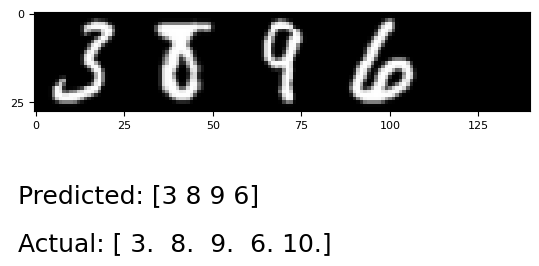

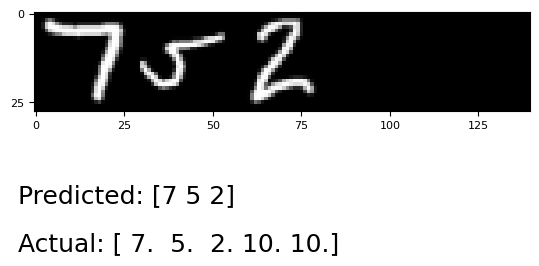

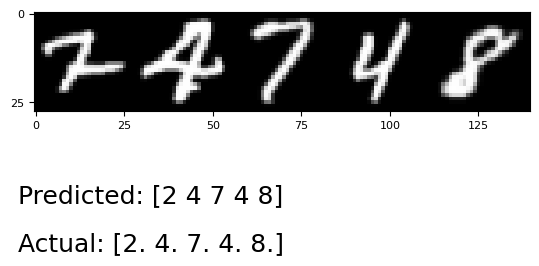

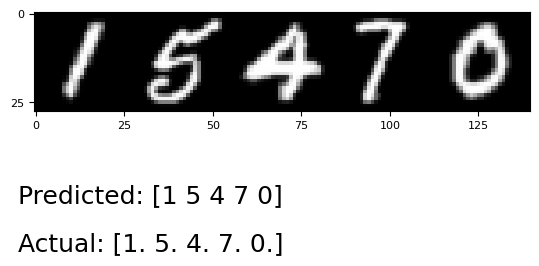

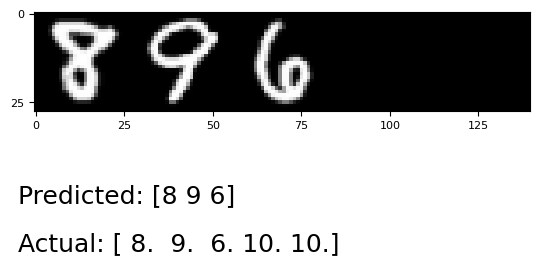

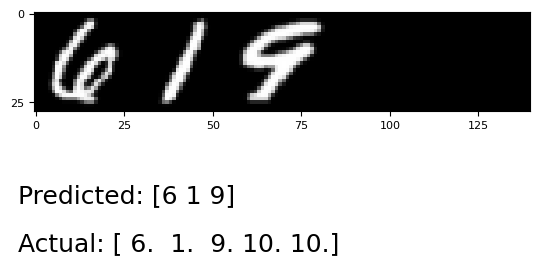

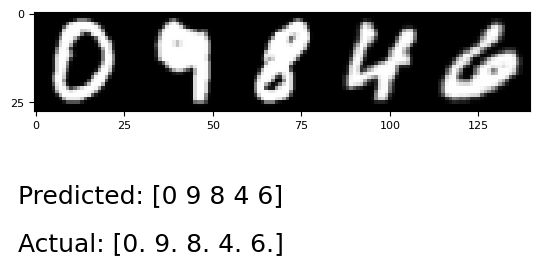

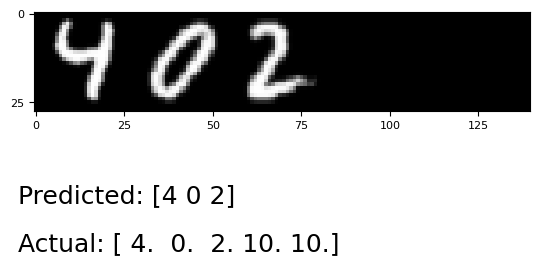

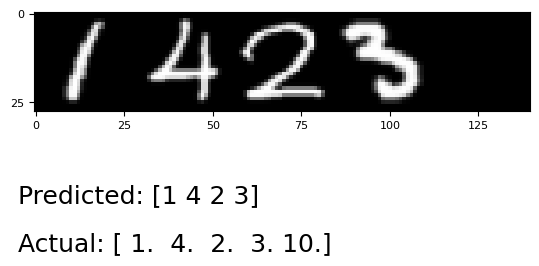

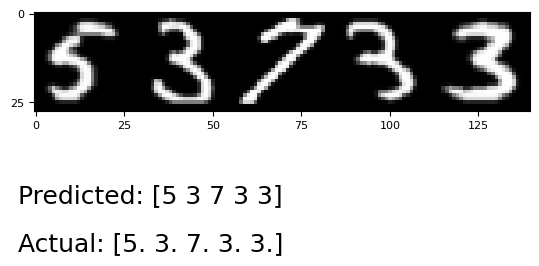

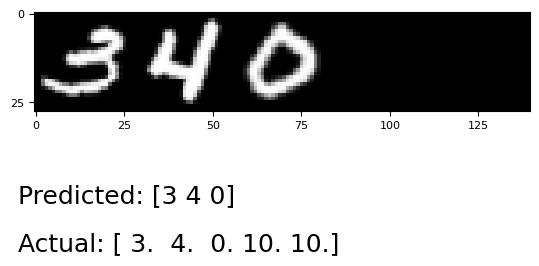

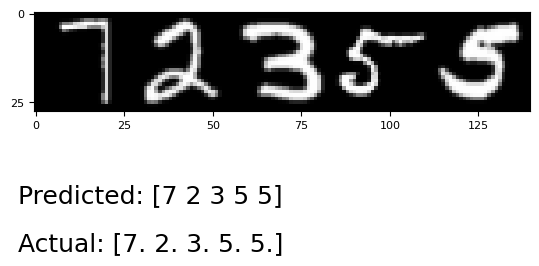

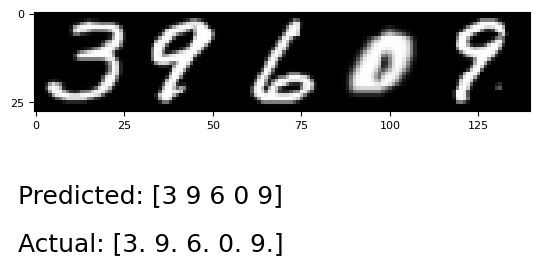

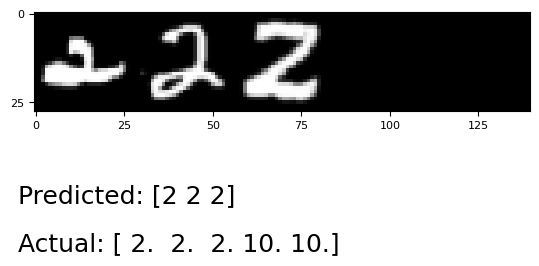

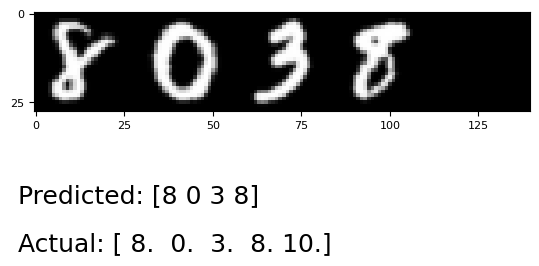

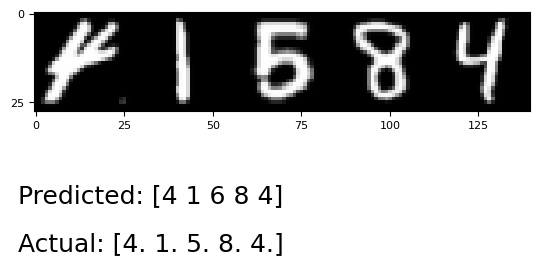

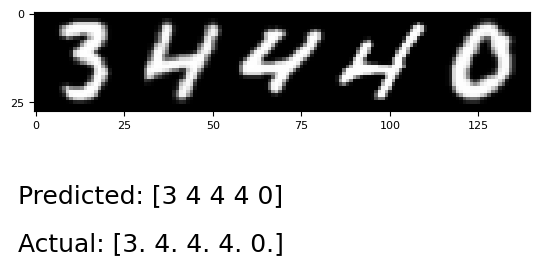

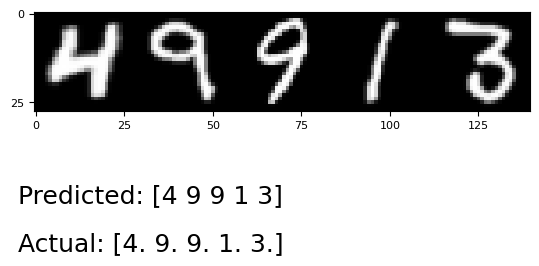

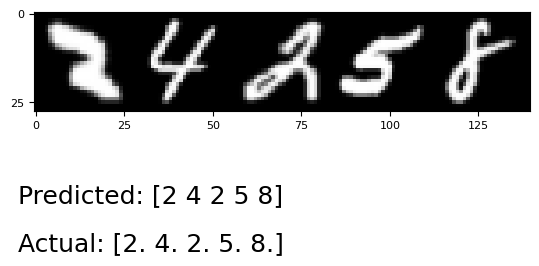

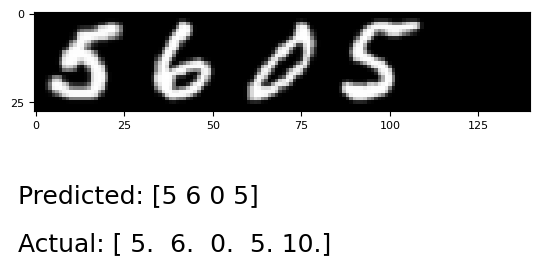

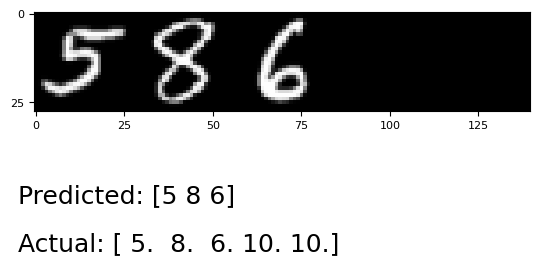

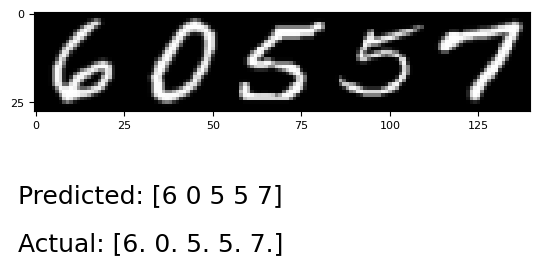

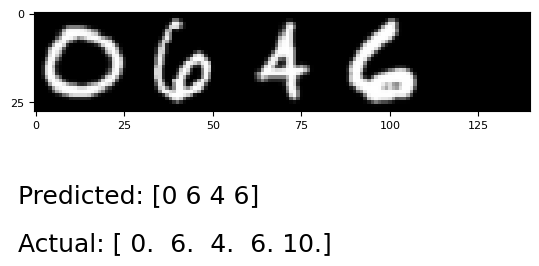

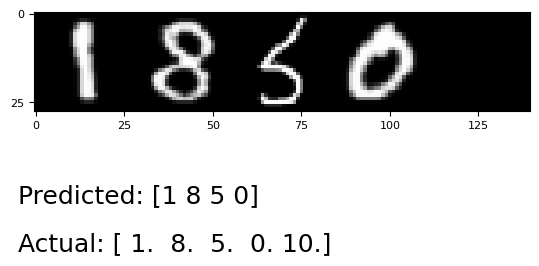

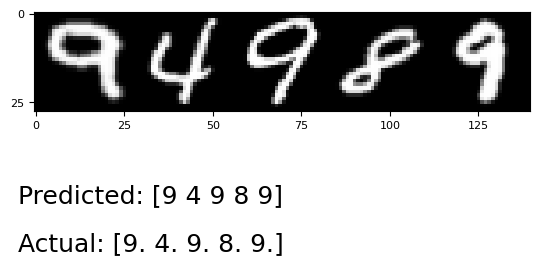

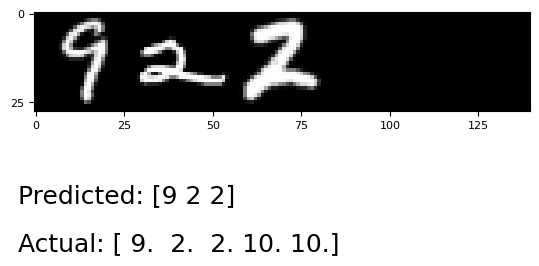

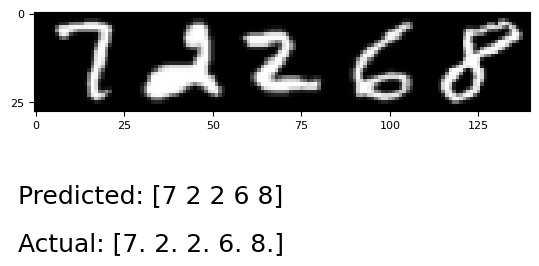

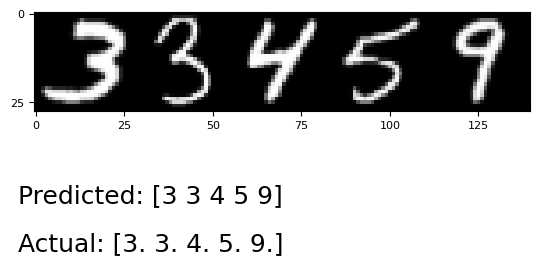

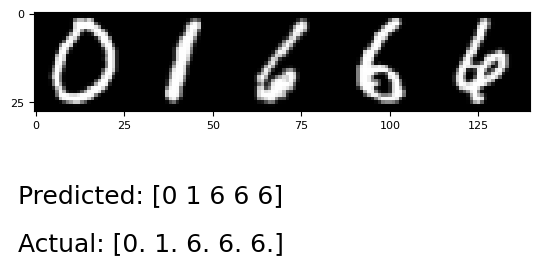

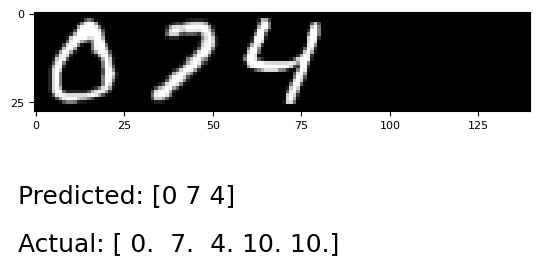

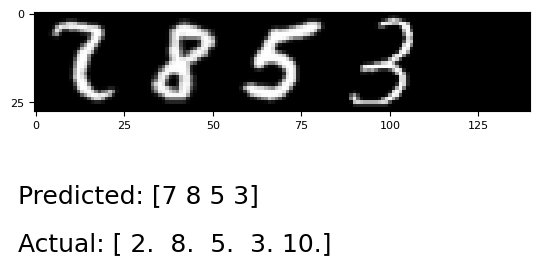

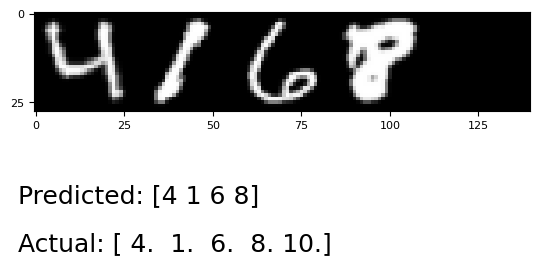

In [32]:
test_model(model, val_loader, config=CONFIG)